## Final Report:
# Control of a Robotic Vacuum Cleaner

Deep Reinforcement Learning (EE 373/473), Spring 2023, Northwestern University.  
Klemens Iten, KlemensIten2023@u.northwestern.edu

This notebook is available online at: https://github.com/Bakeey/rl_gridworld/blob/main/report/deliverable.ipynb  
Youtube Link: https://youtu.be/fciQHOOK4N8

### Introduction

Robotic vacuum cleaners have become a stadard feature in many homes. 
Its objective is to clean all surfaces in a room as efficiently as possible. For this project, a
rectangular room without any obstacles is assumed for simplicity’s sake. 

This
objective with the given system can be modeled as an episodic markov decision process
(MDP):

From a set initial state (charging port), the robotic vacuum cleaner gets positive rewards
for cleaning dirty surfaces (i.e. everytime it visits a new state) and negative rewards for recleaning
previously cleaned surfaces (i.e. states it has visited before). Additionally, a smaller
negative reward can be used to penalize time or battery usage. The episode ends after the
whole room is cleaned (all states visited, large positive terminal reward) or if the battery
runs out (after some fixed time, large negative terminal reward).


<p align="center">
  <img width="460" src="springer.jpg">
  < Two Examples for so-called differential drive robots. Reprinted from [1].
</p>

In reality, these robots are differential-drive robots [2] and must be steered using (at least) two motors in three state dimensions (position $x$ and $y$ as well as orientation $\theta$). We will simplifiy this task to a two-dimensional gridworld problem for the purposes of this project.

Imagine the room being a square grid, similar to a chessboard, with the robot starting in he charging station in the upper left, shown by a blue dot:


<p align="center">
  <img width="200" src="gridworld.png">
  < The robot can move to its neighboring tiles (here: right and down).
</p>

The task can be modeled as an episodic MDP with the following reward structure (code from [Github repo](https://github.com/Bakeey/rl_gridworld/blob/main/rl_gridworld\rl_gridworld\envs\rl_gridworld.py) with adjustments):

In [1]:
import numpy as np

def step(time, agent_location, action, visited_locations, grid_size, battery_life):
    # Map the action (element of {0,1,2,3}) to the direction we walk in
    direction = action
    # We use `np.clip` to make sure we don't leave the grid
    new_agent_location = np.clip(
        agent_location + direction, 0, grid_size
    )
    time += 1 # move 1 timestep forward

    # Add location to set of visited states if it is not yet in it
    if new_agent_location in visited_locations:
        reward = -1 # negative reward for cleaning already clean tile
    else:
        visited_locations = np.append(visited_locations, new_agent_location, axis=0)
        reward = 1 # positive reward for cleaning a previously unvisited tile

    # An episode is done iff the agent has visited all states
    if len(visited_locations) == grid_size**2:
        terminated = True
        reward = 10
    elif battery_life - time <= 0:
        truncated = True
        reward = -10

    return time, new_agent_location, reward, visited_locations

### We perform Q-learning to find the optimal policy:
<p align="left">
  <img width="600" src="q-learning.png">
  < Q-learning as used in this project.
</p>

### Update Q-values with chosen action

In [2]:
def update_q_values(q_values: np.ndarray,
    action: dict[int,np.ndarray],
    agent_location: tuple[int,int],
    next_agent_locations: tuple[int,int],
    learning_rate: float,
    reward: float,
    gamma: float):
    
    # Q = max_a' (r + gamma*Q_next(s', a'))
    # the Q-values of each state and action. Note: q_values.shape = grid_size*grid_size*4!

    q_values[agent_location,action] = (1-learning_rate) * q_values[agent_location,action] +\
                                        learning_rate * (reward + gamma * np.max(q_values[next_agent_locations]))
    return q_values

### Choose Q-values with $\varepsilon$-greedy policy:

In [3]:
def act(self, state):
    if  np.random.random() <= self.epsilon:
        return np.random.randint(0,4)
    else:
        action_values = q_values[state]
        return np.argmax(action_values)

### Illustration of Results: Hyperparameter Study

In [4]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

alphas = np.flip(np.linspace(1,0,20,endpoint=False))
epsilons = np.flip(np.linspace(1,0,21,endpoint=True))
episodes = 1000

rewards_no_decay = np.empty((alphas.shape[0],epsilons.shape[0],episodes),dtype=float)
rewards_decay = np.empty((alphas.shape[0],epsilons.shape[0],episodes),dtype=float)

# retrieving data from file. NOTE you need the results of the parameter as a text file (provided in .zip)
loaded_arr = np.loadtxt("rewards_non_decay.txt")
loaded_arr_2 = np.loadtxt("rewards_decaying.txt")

# This loadedArr is a 2D array, therefore
# we need to convert it to the original
# array shape.reshaping to get original
# matrice with original shape.
rewards = loaded_arr.reshape(
   loaded_arr.shape[0], loaded_arr.shape[1] // rewards_no_decay.shape[2], rewards_no_decay.shape[2])
rewards_decay = loaded_arr_2.reshape(
   loaded_arr_2.shape[0], loaded_arr_2.shape[1] // rewards_no_decay.shape[2], rewards_no_decay.shape[2])

### Illustrating mean return of converged policy for different learning and exploration rates

As you can see below, for non-decaying exploration rates, the mean return is generally much more spread out. For a decaying exploration rate, the mean return converges to either a very bad policy with low return or a very good policy with maximum return!

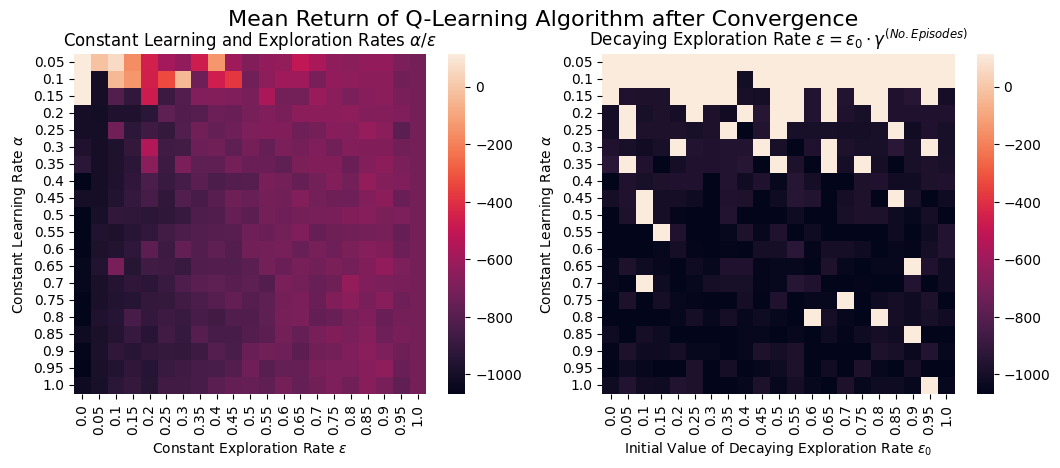

In [5]:
mean_1 = np.empty((alphas.shape[0],epsilons.shape[0]),dtype=float)
mean_2 = np.empty((alphas.shape[0],epsilons.shape[0]),dtype=float)

for ii,alpha in enumerate(alphas):
    for jj,epsilon in enumerate(epsilons):
        mean_1[ii,jj] = np.mean(rewards[ii,jj,-100:])
        mean_2[ii,jj] = np.mean(rewards_decay[ii,jj,-100:])

plt.figure(figsize=(15/1.2,5.3/1.2))
plt.subplot(1,2,1)
s1 = sns.heatmap(mean_1, annot=False, xticklabels=np.round(epsilons,2), yticklabels=np.round(alphas,2))
s1.set(xlabel=r'Constant Exploration Rate $\varepsilon$', ylabel=r'Constant Learning Rate $\alpha$')
plt.title(r'Constant Learning and Exploration Rates $\alpha/\varepsilon$')

plt.subplot(1,2,2)
s2 = sns.heatmap(mean_2, annot=False, xticklabels=np.round(epsilons,2), yticklabels=np.round(alphas,2))
s2.set(xlabel=r'Initial Value of Decaying Exploration Rate $\varepsilon_0$', ylabel=r'Constant Learning Rate $\alpha$')
plt.title(r'Decaying Exploration Rate $\varepsilon=\varepsilon_0\cdot\gamma^{(No. Episodes)}$')
plt.suptitle("Mean Return of Q-Learning Algorithm after Convergence", size=16)
plt.show()

### Illustrating maximum return of converged policy for different learning and exploration rates

The same can be said for the maximum return of the policy after convergence: Without decaying exploration rate, most combinations of non-decaying $\alpha$ and non-decaying $\varepsilon$ have a medium-high maximum return. For the decaying exploration rate, the maximum return observed is either the maximum return possible or a very low return.

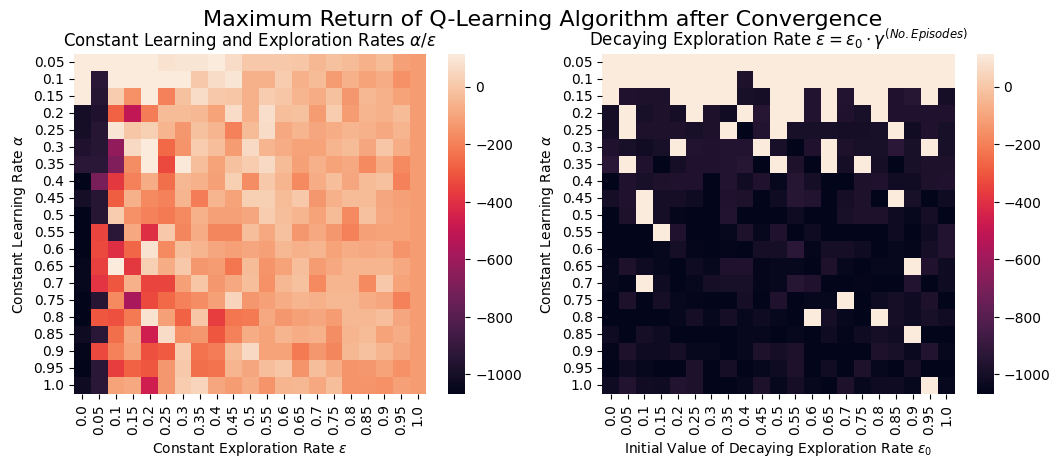

In [6]:
max_1 = np.empty((alphas.shape[0],epsilons.shape[0]),dtype=float)
max_2 = np.empty((alphas.shape[0],epsilons.shape[0]),dtype=float)

for ii,alpha in enumerate(alphas):
    for jj,epsilon in enumerate(epsilons):
        max_1[ii,jj] = np.max(rewards[ii,jj,-100:])
        max_2[ii,jj] = np.max(rewards_decay[ii,jj,-100:])


plt.figure(figsize=(15/1.2,5.3/1.2))
plt.subplot(1,2,1)
s1 = sns.heatmap(max_1, annot=False, xticklabels=np.round(epsilons,2), yticklabels=np.round(alphas,2))
s1.set(xlabel=r'Constant Exploration Rate $\varepsilon$', ylabel=r'Constant Learning Rate $\alpha$')
plt.title(r'Constant Learning and Exploration Rates $\alpha/\varepsilon$')

plt.subplot(1,2,2)
s2 = sns.heatmap(max_2, annot=False, xticklabels=np.round(epsilons,2), yticklabels=np.round(alphas,2))
s2.set(xlabel=r'Initial Value of Decaying Exploration Rate $\varepsilon_0$', ylabel=r'Constant Learning Rate $\alpha$')
plt.title(r'Decaying Exploration Rate $\varepsilon=\varepsilon_0\cdot\gamma^{(No. Episodes)}$')
plt.suptitle("Maximum Return of Q-Learning Algorithm after Convergence", size=16)
plt.show()


### Plotting Rewards at End of each Episode

Below, we plot the observed reward for each episode for 1000 episodes with randomly selected learning and exploration rates. In the upper plot, you can see the observed reward for non-decaying exploration rates $\varepsilon$, and in the lower plot, a decaying exploration rate. 

We can notice that with a decaying $\varepsilon$, the observed return converges to a consistent value (either bad or good), while it fluctuates much more for a constant $\varepsilon$.

In the worst case, a constant $\varepsilon$ can cause the robot to find an optimal policy, but then leaved it again to pursue a sub-optimal policy. 

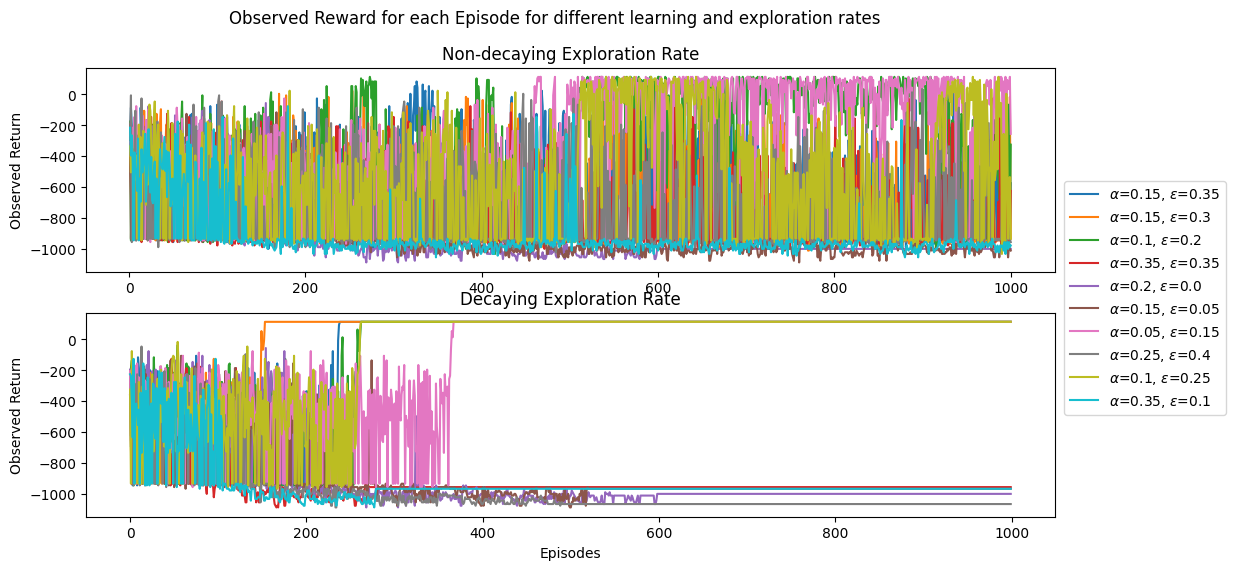

In [7]:
episodes = np.arange(1,1000 + 1)
max_reward = 114 # TODO

fig, axs = plt.subplots(2,1)
fig.set_figheight(7/1.2)
fig.set_figwidth(15/1.2)
fig.suptitle('Observed Reward for each Episode for different learning and exploration rates')

plt.subplot(2,1,1)
for _ in range(10):
    ii,jj = np.random.randint(len(alphas)/2,size=(2,))
    label = r'$\alpha$='+str(round(alphas[ii],2))+r', $\varepsilon$='+str(round(epsilons[jj],2))
    axs[0].plot(episodes, rewards[ii,jj,:], label=label)
    axs[1].plot(rewards_decay[ii,jj,:], label=label)

axs[1].legend(loc=(1.01,.5))
axs[0].title.set_text('Non-decaying Exploration Rate')
axs[1].title.set_text('Decaying Exploration Rate')
axs[1].set_xlabel("Episodes")
axs[0].set_ylabel("Observed Return")
axs[1].set_ylabel("Observed Return")

plt.show()


### Conclusions
After finishing this project, the following conclusions can be drawn:
1.	The robotic vacuum cleaner's objective of cleaning all surfaces in a room can be effectively modeled as an episodic Markov Decision Process (MDP). The MDP formulation allows for defining a reward structure that incentivizes the robot to clean dirty surfaces while penalizing re-cleaning of previously cleaned areas. 
2.	Using Q-learning, an optimal policy can be developed that effectively cleans the given room. 
3.	Due to the simple grid-world structure, training time is negligible, with most of the computational time devoted to visualizing. Without viualizing, trining for hundreds of episodes only takes a few seconds.

Overall, this project demonstrated the feasibility of using reinforcement learning techniques to develop efficient policies this problem.
In the future, this problem can be further developed using more sophisticated algorithms, or moving in the domain for continuous state and actions for the vacuum cleaning robo


### References

1. B. Siciliano and O. Khatib. Springer Handbook of Robotics. Springer-Verlag, Berlin, Heidelberg, 2007. ISBN 354023957X. URL https://doi.org/10.1007/978-3-319-32552-1.
2. R. Siegwart, I. R. Nourbakhsh, and D. Scaramuzza. Introduction to Autonomous Mobile Robots. The MIT Press, Cambridge, Boston, 2nd edition, 2011. ISBN 978-0-262-01535-6. URL https://dl.acm.org/doi/10.5555/1971970.


